# Finding Cycles (with NetworkX)

pynucastro uses [NetworkX](https://networkx.org) internally for the main network plots.  The
graph-representation of a network can be exported so any NetworkX methods can be used on
the network.

Here's an example of finding cycles in a network.

In [1]:
import pynucastro as pyna
import networkx as nx

## A simple CNO / hot-CNO network

We'll create a reaction network that includes CNO, hot-CNO, and some breakout

In [2]:
nuclei = ["p", "he4",
          "c12", "c13",
          "n13", "n14", "n15",
          "o14", "o15", "o16",
          "f17", "f18"]

In [3]:
rl = pyna.ReacLibLibrary()

In [4]:
lib = rl.linking_nuclei(nuclei, with_reverse=False)

In [5]:
rc = pyna.RateCollection(libraries=lib)

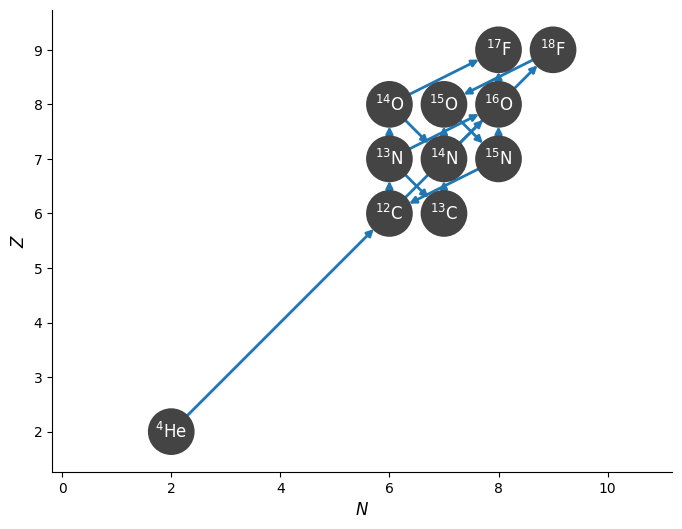

In [6]:
fig = rc.plot(hide_xalpha=True, hide_xp=True)

## Finding all cycles

Now we can use the {py:func}`create_network_graph <pynucastro.networks.rate_collection.RateCollection.create_network_graph>` function to export a NetworkX graph object.  This function can take many of the same filtering options as `plot()`, which is useful for removing links that you don't want NetworkX to consider.

In [7]:
G = rc.create_network_graph(rc.unique_nuclei, hide_xalpha=True, hide_xp=True)

In [8]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

Now we'll use the [simple_cycles](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.simple_cycles.html) algorithm to find the cycles.

In [9]:
cycles = nx.simple_cycles(G)
for n, c in enumerate(cycles):
    print(n, c)

0 [C12, N13, C13, N14, O15, N15]
1 [C12, N13, C13, N14, F18, O15, N15]
2 [C12, N13, O14, N14, O15, N15]
3 [C12, N13, O14, N14, F18, O15, N15]


Cycle 0 is the traditional CNO cycle and cycle 2 is the hot-CNO cycle.

Of course, which cycles are actually active depends on the values of the rates linking the nuclei, and therefore the thermodynamic state.  We can look at this.

## Using thermodynamic info to constrain cycles

Let's pick a thermodynamic state this is not hot enough to expect breakout from hot-CNO

In [10]:
rho = 1.e4
T = 5.e7
comp = pyna.Composition(rc.unique_nuclei)
comp.set_equal()

In [11]:
rates = rc.evaluate_rates(rho=rho, T=T, composition=comp)
rates

{N13 ⟶ C13 + e⁺ + 𝜈: 7.4302131845073905e-06,
 O14 ⟶ N14 + e⁺ + 𝜈: 5.8440350154741495e-05,
 O15 ⟶ N15 + e⁺ + 𝜈: 3.1564204422233696e-05,
 C12 + p ⟶ N13 + 𝛾: 9.694296692196057e-08,
 C12 + He4 ⟶ O16 + 𝛾: 6.282274846725595e-28,
 C13 + p ⟶ N14 + 𝛾: 2.9228808030548344e-07,
 N13 + p ⟶ O14 + 𝛾: 4.690032675727115e-09,
 N14 + p ⟶ O15 + 𝛾: 1.0422887941879326e-09,
 N14 + He4 ⟶ F18 + 𝛾: 3.665206616458353e-33,
 N15 + p ⟶ O16 + 𝛾: 2.5109263031043633e-08,
 O16 + p ⟶ F17 + 𝛾: 8.575361649785872e-11,
 N13 + He4 ⟶ p + O16: 1.6721043456697185e-24,
 N15 + p ⟶ He4 + C12: 6.12942074025757e-05,
 O14 + He4 ⟶ p + F17: 1.4505398114303725e-30,
 F18 + p ⟶ He4 + O15: 1.3881422851714005e-07,
 3 He4 ⟶ C12 + 𝛾: 1.3506078675867418e-34}

### First attempt: cut by rate value

Now we'll disable any rates that are really small.  We can do this with `ydot_cutoff_value` --- this same parameter is available in `plot()`, so we can test it there.

Looking at the above, we'll disable any rate that is smaller than $10^{-20}$

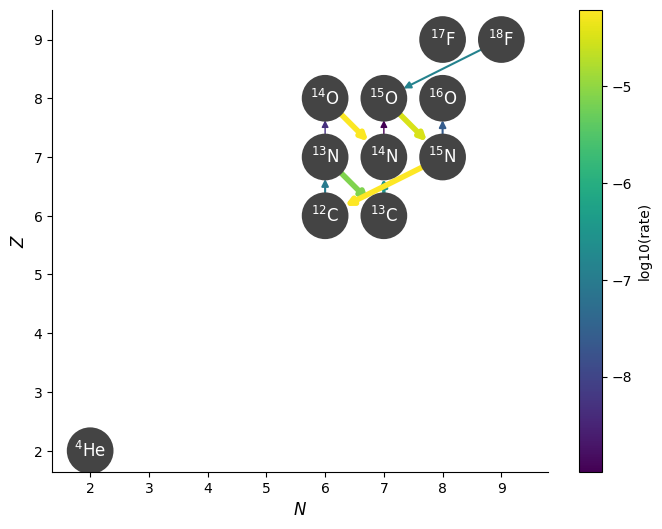

In [12]:
fig = rc.plot(hide_xalpha=True, hide_xp=True,
              rho=rho, T=T, comp=comp,
              ydot_cutoff_value=1.e-10)

Now a lot of rates connecting to the $\mathrm{F}$ isotopes are gone.

Now let's re-export the network graph and look for cycles

In [13]:
G = rc.create_network_graph(rc.unique_nuclei,
                            rate_ydots=rates, ydot_cutoff_value=1.e-20,
                            hide_xalpha=True, hide_xp=True)

In [14]:
cycles = nx.simple_cycles(G)
for n, c in enumerate(cycles):
    print(n, c)

0 [C12, N13, C13, N14, O15, N15]
1 [C12, N13, O14, N14, O15, N15]


Now we see that only the CNO and hot-CNO cycles exist for these conditions.

### Second attempt: cutting by branching

Instead of using the value of the rate, we can instead look at each nucleus and consider all the rates that consume it.  We can filter out any rates that are below a threshold compared to the maximum rate consuming that nucleus.  This is done via `consuming_rate_threshold`.

First let's visualize this.

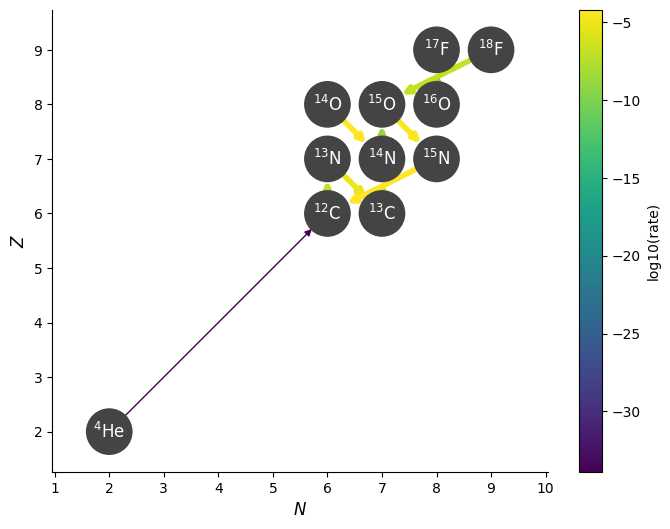

In [15]:
fig = rc.plot(hide_xalpha=True, hide_xp=True,
              rho=rho, T=T, comp=comp,
              consuming_rate_threshold=0.1)

We see that this has filtered out the proton capture on ${}^{13}\mathrm{N}$, removing the hot-CNO cycle.

Now let's recreate the network graph using this filtering.

In [16]:
G = rc.create_network_graph(rc.unique_nuclei,
                            rate_ydots=rates, consuming_rate_threshold=0.1,
                            hide_xalpha=True, hide_xp=True)

In [17]:
cycles = nx.simple_cycles(G)
for n, c in enumerate(cycles):
    print(n, c)

0 [C12, N13, C13, N14, O15, N15]


Now, as expected, only a single cycle is really dominate under these conditions --- the CNO cycle.

What happens if we make it hotter?

In [18]:
T = 5.e8
rates = rc.evaluate_rates(rho=rho, T=T, composition=comp)

In [19]:
G = rc.create_network_graph(rc.unique_nuclei,
                            rate_ydots=rates, consuming_rate_threshold=0.1,
                            hide_xalpha=True, hide_xp=True)

In [20]:
cycles = nx.simple_cycles(G)
for n, c in enumerate(cycles):
    print(n, c)

0 [C12, N13, O14, N14, O15, N15]


Now we see that the hot-CNO cycle is the one that dominates!